<a href="https://colab.research.google.com/github/zlqhem/mlapi/blob/main/torchscript.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
model_file = '/content/drive/MyDrive/w2/flutter/best.torchscript'
image_file = '/content/drive/MyDrive/w2/flutter/strawberry-healthy.png'
img=image_file

classes = np.array([
  'Tomato Healthy',
  'Strawberry Healthy',
  'Lettuce Healthy',
  'Strawberry Ashy Mold',
  'Strawberry White Powdery Mildew',
  'Lettuce Bacterial Head Rot',
  'Lettuce Bacterial Wilt',
  'Tomato Leaf Mold',
  'Tomato Yellow Leaf Curl Virus',
])

# torchscript

## load a model from S3

In [9]:
%%capture
!pip install boto3 python-dotenv

In [10]:
# aws access key setup
import dotenv
# contains 'AWS_ACCESS_KEY', 'AWS_SCRET_ACCESS_KEY'
env_file = "/content/drive/MyDrive/w2/mlapi/aws.env"
dotenv.load_dotenv(env_file)

True

In [11]:
try:
    import unzip_requirements
except ImportError:
    pass

import json
from io import BytesIO
import time
import os
import base64

import boto3
import numpy as np
from PIL import Image

import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F

s3 = boto3.client("s3")
bucket = "soltware.test"
key = "v1/best.torchscript"

def download_model(s3, bucket, key):
    file_name = os.path.basename(key)
    print ('file_name', file_name)
    s3.download_file(bucket, key, file_name)


def load_model(s3, bucket):
  response = s3.get_object(Bucket=bucket, Key=key)
  #state = torch.load(BytesIO(response["Body"].read()))
  #model.load_state_dict(state)
  #model.eval()

  bytes_array = BytesIO(response["Body"].read())
  model = torch.jit.load(bytes_array, map_location=torch.device('cpu')).eval()
  return model

In [12]:
download_model(s3, bucket, key)

file_name best.torchscript


In [13]:
!ls -al best.torchscript

-rw-r--r-- 1 root root 103561564 Apr 14 15:05 best.torchscript


In [14]:
model = load_model(s3, bucket)

In [15]:
model

RecursiveScriptModule(original_name=DetectionModel)

## lambda handler

In [39]:
classes = np.array([
  'Tomato Healthy',
  'Strawberry Healthy',
  'Lettuce Healthy',
  'Strawberry Ashy Mold',
  'Strawberry White Powdery Mildew',
  'Lettuce Bacterial Head Rot',
  'Lettuce Bacterial Wilt',
  'Tomato Leaf Mold',
  'Tomato Yellow Leaf Curl Virus',
])

input_width=640
input_height=640
conf_threshold=0.3
iou_threshold=0.5

def lambda_handler(event, context):
    '''
    if event.get("source") in ["aws.events", "serverless-plugin-warmup"]:
        print('Lambda is warm!')
        return {}
    '''

    data = json.loads(event["body"])
    print("data keys:", data.keys())
    image = data["image"]
    img_width = data["width"]
    img_height = data["height"]

    response = predict(input_fn_stream(image), model, img_width, img_height)

    return {
        'statusCode': 200,
        'headers': {
            "Access-Control-Allow-Headers": "*",
            "Access-Control-Allow-Origin": "*", # Required for CORS support to work
            "Access-Control-Allow-Methods": "*",
            "Accept": "*/*",
            "Access-Control-Allow-Credentials": "true", # Required for cookies, authorization headers with HTTPS
        },
        'body': json.dumps(response)
    }

def input_fn_stream(image):
    image = image[image.find(",")+1:]
    dec = base64.b64decode(image + "===")
    byte_array = BytesIO(dec)

    # FIXME: get model input shape.
    input_widh = 640
    input_height = 640
    im = Image.open(byte_array).resize((input_widh,input_height))
    im = im.convert("RGB")

    #https://dev.to/andreygermanov/how-to-create-yolov8-based-object-detection-web-service-using-python-julia-nodejs-javascript-go-and-rust-4o8e#prepare_the_input
    # "We do not need Alpha channel in the image for YOLOv8 predictions. Let's remove it"
    input = np.array(im)
    input = input.transpose(2,0,1)
    input = input.reshape(1,3,input_widh,input_height)
    input = input/255.0
    return torch.Tensor(input)

'''
{'predictions':
  [{'x': 1012.0, 'y': 593.5, 'width': 406.0, 'height': 443.0, 'confidence': 0.7369905710220337, 'class': 'Paper',
   'image_path': 'example.jpg', 'prediction_type': 'ObjectDetectionModel'}],
  'image': {'width': 1436, 'height': 956}}
'''
#https://github.com/ibaiGorordo/ONNX-YOLOv8-Object-Detection/blob/main/yolov8%2FYOLOv8.py#L66
def predict(img_tensor, model, img_width, img_height):
  outputs = model(img_tensor)
  boxes, scores, class_ids = process_output(outputs, img_width, img_height)
  for box, score, class_id in zip(boxes, scores, class_ids):
    print(box, score, class_id)

  response = {}
  #[x,y,x,y]
  response['boxes'] = str(boxes)
  response['scores'] = str(scores)
  response['class_ids'] = str(class_ids)
  response['labels'] = str([classes[id] for id in class_ids])
  print(response)
  return response

def process_output(output, img_width, img_height):
    #// yolov8 has an output of shape (batchSize, 84,  8400) (Num classes + box[x,y,w,h])
    output = output.numpy()
    predictions = np.squeeze(output[0]).T

    print('predictions.shape', predictions.shape)
    print('pred[0] box', predictions[0][:4])
    # Filter out object confidence scores below threshold
    scores = np.max(predictions[:, 4:], axis=1)
    predictions = predictions[scores > conf_threshold, :]
    scores = scores[scores > conf_threshold]

    if len(scores) == 0:
        return [], [], []

    # Get the class with the highest confidence
    class_ids = np.argmax(predictions[:, 4:], axis=1)

    # Get bounding boxes for each object
    boxes = extract_boxes(predictions, img_width, img_height)

    # Apply non-maxima suppression to suppress weak, overlapping bounding boxes
    # indices = nms(boxes, scores, self.iou_threshold)
    indices = multiclass_nms(boxes, scores, class_ids, iou_threshold)

    return boxes[indices], scores[indices], class_ids[indices]

def extract_boxes(predictions, img_width, img_height):
    # Extract boxes from predictions
    boxes = predictions[:, :4]

    # Scale boxes to original image dimensions
    boxes = rescale_boxes(boxes, img_width, img_height)

    # Convert boxes to xyxy format
    boxes = xywh2xyxy(boxes)

    return boxes

def rescale_boxes(boxes, img_width, img_height):

    # Rescale boxes to original image dimensions
    input_shape = np.array([input_width, input_height, input_width, input_height])
    boxes = np.divide(boxes, input_shape, dtype=np.float32)
    boxes *= np.array([img_width, img_height, img_width, img_height])
    return boxes

def xywh2xyxy(x):
    # Convert bounding box (x, y, w, h) to bounding box (x1, y1, x2, y2)
    y = np.copy(x)
    y[..., 0] = x[..., 0] - x[..., 2] / 2
    y[..., 1] = x[..., 1] - x[..., 3] / 2
    y[..., 2] = x[..., 0] + x[..., 2] / 2
    y[..., 3] = x[..., 1] + x[..., 3] / 2
    return y

def multiclass_nms(boxes, scores, class_ids, iou_threshold):

    unique_class_ids = np.unique(class_ids)

    keep_boxes = []
    for class_id in unique_class_ids:
        class_indices = np.where(class_ids == class_id)[0]
        class_boxes = boxes[class_indices,:]
        class_scores = scores[class_indices]

        class_keep_boxes = nms(class_boxes, class_scores, iou_threshold)
        keep_boxes.extend(class_indices[class_keep_boxes])

    return keep_boxes

def nms(boxes, scores, iou_threshold):
    # Sort by score
    sorted_indices = np.argsort(scores)[::-1]

    keep_boxes = []
    while sorted_indices.size > 0:
        # Pick the last box
        box_id = sorted_indices[0]
        keep_boxes.append(box_id)

        # Compute IoU of the picked box with the rest
        ious = compute_iou(boxes[box_id, :], boxes[sorted_indices[1:], :])

        # Remove boxes with IoU over the threshold
        keep_indices = np.where(ious < iou_threshold)[0]

        # print(keep_indices.shape, sorted_indices.shape)
        sorted_indices = sorted_indices[keep_indices + 1]

    return keep_boxes

def compute_iou(box, boxes):
    # Compute xmin, ymin, xmax, ymax for both boxes
    xmin = np.maximum(box[0], boxes[:, 0])
    ymin = np.maximum(box[1], boxes[:, 1])
    xmax = np.minimum(box[2], boxes[:, 2])
    ymax = np.minimum(box[3], boxes[:, 3])

    # Compute intersection area
    intersection_area = np.maximum(0, xmax - xmin) * np.maximum(0, ymax - ymin)

    # Compute union area
    box_area = (box[2] - box[0]) * (box[3] - box[1])
    boxes_area = (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])
    union_area = box_area + boxes_area - intersection_area

    # Compute IoU
    iou = intersection_area / union_area

    return iou

path = "/content/drive/MyDrive/w2/flutter/strawberry-healthy.png"

with open(path, "rb") as image_file:
  encoded_string = base64.b64encode(image_file.read()).decode('utf-8')

print (len(encoded_string))

url = "TBD"
width, height = 768, 576
data =  {
    "image": encoded_string,
    "width": width,
    "height": height
}

y = predict(input_fn_stream(encoded_string), model, width, height)

844988
predictions.shape (8400, 13)
pred[0] box [15.856949  9.936804 32.870415 20.017097]
[249.27716 174.08672 542.8576  451.1772 ] 0.9661918 1
{'boxes': '[[249.27716 174.08672 542.8576  451.1772 ]]', 'scores': '[0.9661918]', 'class_ids': '[1]', 'labels': "['Strawberry Healthy']"}


In [17]:
body = json.dumps(data)
res = lambda_handler({"body": body}, {})
print(res)
body = res["body"]
json_data = json.loads(body)
print(json_data)

data keys: dict_keys(['image'])
predictions.shape (8400, 13)
pred[0] box [15.856949  9.936804 32.870415 20.017097]
[207.73096 193.42969 452.38135 501.30798] 0.9661918 1
{'boxes': '[[207.73096 193.42969 452.38135 501.30798]]', 'scores': '[0.9661918]', 'class_ids': '[1]', 'labels': "['Strawberry Healthy']"}
{'statusCode': 200, 'headers': {'Access-Control-Allow-Headers': '*', 'Access-Control-Allow-Origin': '*', 'Access-Control-Allow-Methods': '*', 'Accept': '*/*', 'Access-Control-Allow-Credentials': 'true'}, 'body': '{"boxes": "[[207.73096 193.42969 452.38135 501.30798]]", "scores": "[0.9661918]", "class_ids": "[1]", "labels": "[\'Strawberry Healthy\']"}'}
{'boxes': '[[207.73096 193.42969 452.38135 501.30798]]', 'scores': '[0.9661918]', 'class_ids': '[1]', 'labels': "['Strawberry Healthy']"}


### visualize object detection

h,w 576 768


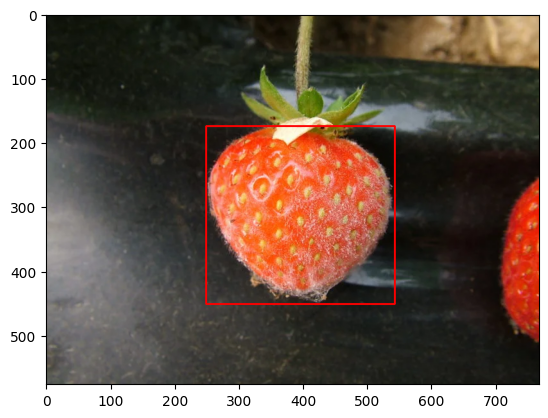

In [42]:
'''
{'predictions':
  [{'x': 1012.0, 'y': 593.5, 'width': 406.0, 'height': 443.0, 'confidence': 0.7369905710220337, 'class': 'Paper',
   'image_path': 'example.jpg', 'prediction_type': 'ObjectDetectionModel'}],
  'image': {'width': 1436, 'height': 956}}
'''
import cv2
import matplotlib.pyplot as plt
image = cv2.imread(path)
h, w, c = image.shape

print('h,w',h,w)
p1, p2 = (249.27716, 174.08672), (542.8576,  451.1772)
p1, p2 = (249, 174), (543,  451)

cv2.rectangle(image, p1, p2, color=(0,0,255), thickness=2)

# RGB
img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## Use the deployed API


In [ ]:
path = "/content/drive/MyDrive/w2/flutter/strawberry-healthy.png"

with open(path, "rb") as image_file:
  encoded_string = base64.b64encode(image_file.read()).decode('utf-8')

print (len(encoded_string))

data =  {
    "image": encoded_string
}

844988


In [ ]:
%%time
import requests
# 04-01
url = 'https://ql824ne57l.execute-api.us-east-1.amazonaws.com/detect'
url = 'https://ql824ne57l.execute-api.us-east-1.amazonaws.com/Prod/detect'
response = requests.post(url, json=data)
response.content

CPU times: user 145 ms, sys: 12.4 ms, total: 157 ms
Wall time: 17.6 s


b'{"boxes": "[[207.73096 193.42969 452.38135 501.30798]]", "scores": "[0.9661918]", "class_ids": "[1]", "labels": "[\'Strawberry Healthy\']"}'

## references

* https://github.com/ahmedbesbes/cartoonify/tree/main
* https://github.com/ibaiGorordo/ONNX-YOLOv8-Object-Detection/blob/main/yolov8%2FYOLOv8.py#L66

# Amazon ECR(Elastic Container Registry) test

hugging face transformer model

In [ ]:
url="https://umep4240p5.execute-api.us-east-1.amazonaws.com/inference"
%time !curl --header "Content-Type: application/json" --request POST --data '{"question": "When was the car invented?","context": "Cars came into global use during the 20th century, and developed economies depend on them. The year 1886 is regarded as the birth year of the modern car when German inventor Karl Benz patented his Benz Patent-Motorwagen. Cars became widely available in the early 20th century. One of the first cars accessible to the masses was the 1908 Model T, an American car manufactured by the Ford Motor Company. Cars were rapidly adopted in the US, where they replaced animal-drawn carriages and carts, but took much longer to be accepted in Western Europe and other parts of the world."}' https://umep4240p5.execute-api.us-east-1.amazonaws.com/inference

{"Question": "When was the car invented?", "Answer": "1886"}CPU times: user 8.03 ms, sys: 1.95 ms, total: 9.98 ms
Wall time: 907 ms
